In [1]:
import os
EXAMPLE_DIR = os.getcwd()
os.chdir(os.path.join('..', '..'))
PROJECT_DIR = os.getcwd()
EXAMPLE_NAME = os.path.basename(EXAMPLE_DIR)
print('EXAMPLE_DIR: ', EXAMPLE_DIR)
print('PROJECT_DIR: ', PROJECT_DIR)

# jupyter-notebook --notebook-dir=$PWD --port=8889 --ip=0.0.0.0

EXAMPLE_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing_extended
PROJECT_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox


In [2]:
%load_ext autoreload
%autoreload 2
import sys
import gym
import time
import dill
import numpy as np
import networkx as nx
from typing import List
from collections import defaultdict

sys.path.append(os.path.join(PROJECT_DIR, 'src'))
from src.graph import Graph
from src.graph import graph_factory
from src.config import ROOT_PATH
from src.strategy_synthesis.multiobjective_solver import MultiObjectiveSolver
from src.graph.trans_sys import FiniteTransSys
from src.spot.Parser import ANDExpression, SymbolExpression, NotSymbolExpression, TrueExpression
from wombats.systems.minigrid import DynamicMinigrid2PGameWrapper, GYM_MONITOR_LOG_DIR_NAME, BoxPacking

Graph.graph_dir = EXAMPLE_DIR

In [3]:
debug = True

dfa_config_yaml="config/DFA"
pdfa_config_yaml="config/PDFA"
strategy_config_yaml="config/Strategy"

# Graph Arguments
load_game_from_file = False
plot_minigrid = False
plot_pdfa = True
plot_product = False
finite = True
view = True
save_flag = True
format = 'png'

# Multi-Objective Optimizer Arguments
stochastic = False
adversarial = True
plot_strategies=False
plot_graph_with_strategy = False
plot_graph_with_pareto = False
plot_pareto = True
speedup = True

NUM_OBJ = 3
PLAYER_MAPPING = {'eve': 'sys', 'adam': 'env'}

ROS_PACKAGE_DIR = os.path.join(PROJECT_DIR, '..')
STRATEGY_PICKLE_FILENAME = os.path.join(ROS_PACKAGE_DIR, 'python_examples', 'strategy.pickle')
LOCATION_MAPPINGS_PICKLE_FILENAME = os.path.join(ROS_PACKAGE_DIR, 'python_examples', 'location_mappings.pickle')

ADD_SYS_WEIGHT = True
ADD_ENV_WEIGHT = True

NUM_LOCATION = 3

ENV_ID = 'MiniGrid-Franka-BoxPacking-v0'



# Construct DFA and Manually Specify PDFA from DFA 



/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing_extended/plots/pdfa2.png


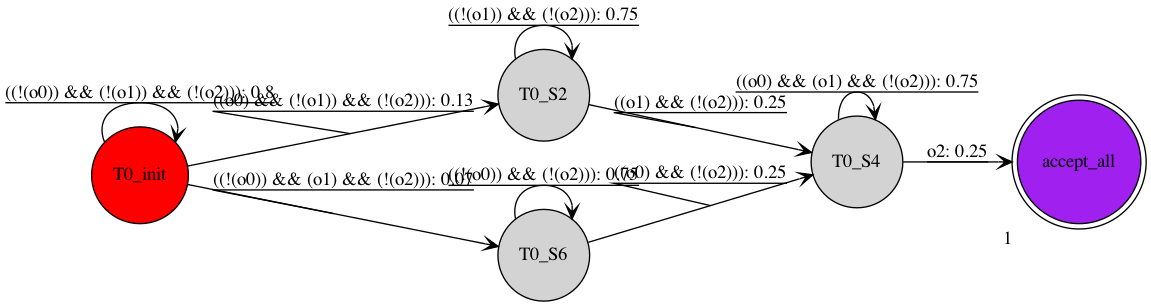

In [4]:
# PDFA
pdfa = graph_factory.get(
    'PDFA',
    graph_name="pdfa2",
    config_yaml=pdfa_config_yaml,
    save_flag=save_flag,
    plot=plot_pdfa,
    view=view,
    format=format)

# Define a Franka environment

In [5]:
LOCATIONS = ['L0', 'L1', 'L2', 'L3']
OBJECT_LOCATIONS = {
    'o0': 'L0', 
    'o1': 'L1', 
    'o2': 'L2'}
TARGET_LOCATIONS = ['L3', 'L3', 'L3']
LOCATION_MAPPINGS = {
    'H':  np.array([  0,   0, 0.085]),
    'L0': np.array([0.6, 0.6, 0.085]),
    'L1': np.array([0.5, -0.5, 0.085]),
    'L2': np.array([0.0, 0.3, 0.085]),
    'L3': np.array([0.3, 0, 0.085]),
}

world_config_kwargs = {
    'locations': LOCATIONS,
    'object_locations': OBJECT_LOCATIONS,
    'target_locations': TARGET_LOCATIONS,
    'distance_mappings': BoxPacking.locations_to_distance_mappings(LOCATION_MAPPINGS)}
env = gym.make(ENV_ID, **world_config_kwargs)
env = DynamicMinigrid2PGameWrapper(
        env,
        player_steps={'sys': [1], 'env': [1]},
        monitor_log_location=os.path.join(EXAMPLE_DIR, GYM_MONITOR_LOG_DIR_NAME))

/Users/kandai/.pyenv/versions/anaconda3-5.3.0/envs/adam_can_play_any_strategy/lib/python3.8/site-packages/gym/wrappers/monitor.py:31: UserWarning: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  warnings.warn(


In [6]:
file_name = ENV_ID + 'Game'
filepath = os.path.join(EXAMPLE_DIR, 'config', file_name)
config_yaml = os.path.relpath(filepath, ROOT_PATH)

# Game Construction
start = time.time()
trans_sys = graph_factory.get('TwoPlayerGraph',
                              graph_name='TwoPlayerGame',
                              config_yaml=config_yaml,
                              minigrid=env,
                              save_flag=save_flag,
                              plot=plot_minigrid,
                              view=view,
                              format=format)
end = time.time()

((<FrankaState.Ready: 0>, 'L3'), (<HumanState.Intervene: 1>, (((<ObjectState.Ready: 0>, 'L3', 2, 1), (<ObjectState.Intervene: 5>, 'L3', 1, 0), (<ObjectState.Ready: 0>, 'L0', 0, 0)), 'sys')))
[list([<FrankaAction.transitGraspToo0: 0>]) list([None])]
((<FrankaState.Ready: 0>, 'L3'), (<HumanState.Intervene: 1>, (((<ObjectState.Ready: 0>, 'L3', 2, 1), (<ObjectState.Intervene: 5>, 'L3', 1, 0), (<ObjectState.Ready: 0>, 'L0', 0, 0)), 'sys')))
[list([<FrankaAction.transitGraspToo1: 1>]) list([None])]
[list([<FrankaAction.transitGraspToo2: 2>]) list([None])]
((<FrankaState.Ready: 0>, 'L3'), (<HumanState.Intervene: 1>, (((<ObjectState.Ready: 0>, 'L3', 2, 1), (<ObjectState.Intervene: 5>, 'L3', 1, 0), (<ObjectState.Ready: 0>, 'L0', 0, 0)), 'sys')))
[list([<FrankaAction.transferReleaseToL0: 3>]) list([None])]
[list([<FrankaAction.transferReleaseToL1: 4>]) list([None])]
[list([<FrankaAction.transferReleaseToL2: 5>]) list([None])]
[list([<FrankaAction.transferReleaseToL3: 6>]) list([None])]
[list([<F

In [7]:
init_node = trans_sys.get_initial_states()[0][0]
# trans_sys.plot_graph(format=format, view=False, start_node=init_node, n_neighbor=5)
# trans_sys.plot_graph(format=format, view=False)

# Manually Define Game
Given a list of objects, construct a product graph


In [8]:
# Product Game Construction
start = time.time()
game = graph_factory.get('ProductGraph',
    graph_name=f'{EXAMPLE_NAME}_ProductAutomaton',
    config_yaml=None,
    trans_sys=trans_sys,
    automaton=pdfa,
    save_flag=True,
    prune=False,
    debug=False,
    absorbing=True,
    finite=finite,
    plot=plot_product,
    integrate_accepting=True,
    view=view,
    format=format)
end = time.time()
print(f'Product Construction took {end-start:.2f} seconds')

Product Construction took 11.80 seconds


In [9]:
# game.plot_graph(view=view, format=format)

29293 nodes and 60494 edges
1th Iteration took 69.82 seconds
2th Iteration took 77.98 seconds
3th Iteration took 122.57 seconds
4th Iteration took 113.32 seconds
5th Iteration took 207.48 seconds
6th Iteration took 144.29 seconds
7th Iteration took 155.11 seconds
8th Iteration took 164.44 seconds
9th Iteration took 132.82 seconds
Pareto Points Computation took 1201.59 seconds


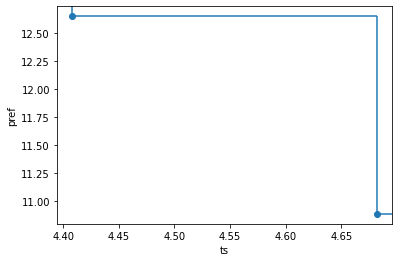

(array([[ 4.40802438, 12.65342856],
        [ 4.68174964, 10.88366106]]),
 {(4.408024375005969,
   12.653428558368578): <src.prism.strategy.DeterministicStrategy at 0x7f7f21a51100>,
  (4.6817496437797645,
   10.883661060155227): <src.prism.strategy.DeterministicStrategy at 0x7f7f21a41790>})

In [10]:
solver = MultiObjectiveSolver(game,
                            epsilon=1e-5,
                            max_iteration=300,
                            stochastic=stochastic,
                            adversarial=adversarial)
solver.solve(plot_strategies=plot_strategies,
                plot_graph_with_strategy=plot_graph_with_strategy,
                plot_graph_with_pareto=plot_graph_with_pareto,
                plot_pareto=plot_pareto,
                speedup=speedup,
                debug=debug,
                view=view,
                format=format)

In [11]:
# strategies = solver.get_strategies()
# strategy = list(strategies.values())[0]
# strategy._config_yaml = "config/Strategy"
# strategy.plot_graph(view=view, format=format, save_yaml=True)

for i, strategy in enumerate(list(solver.get_strategies().values())):
    strategy._config_yaml = f"config/Strategy{i}"
    strategy.plot_graph(view=False, format=format)

    STRATEGY_PICKLE_FILENAME = os.path.join(EXAMPLE_DIR, '3', f'Strategy{i}.pickle')

    try:
        with open(STRATEGY_PICKLE_FILENAME, 'wb') as f:
            dill.dump(strategy, f)

        print(f'File Saved as {STRATEGY_PICKLE_FILENAME}')
    except Exception as e:
        print(e)
        raise e

File Saved as /Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing_extended/3/Strategy0.pickle
File Saved as /Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing_extended/3/Strategy1.pickle


# TODO:
1. Read the strategy file
2. The system agent takes an action
3. Let the env chooses its action
4. Transit to the next system state (Be able to Identify the current state from the object locations)
5. 2-3
6. Check whether the current state is in the accepting state

In [12]:
def run(filename: str):
    with open(filename, 'rb') as f:
        strategy = dill.load(f)

    print('-'*100)
    print(f"Evaluate for a pareto point {strategy._init_pareto_point}")
    print('-'*100)

    runs_per_pareto, actions_per_pareto, cost_per_pareto, obs_per_pareto = strategy.get_max_cost_runs()

    for p, plays in actions_per_pareto.items():
        print('='*100)
        print(f'Pareto Point {p}')
        print('='*100)

        costs = cost_per_pareto[p]
        obss = obs_per_pareto[p]

        for i, play in enumerate(plays):
            
            play_cost = costs[i]
            obs = obss[i]
            print(f'Play {i}: Cost={np.sum(play_cost, axis=0)}')

            for actions, c, o in zip(play, play_cost, obs):
                print('\t', actions, c, o)
                

In [13]:
filename = os.path.join(EXAMPLE_DIR, '3', 'Strategy0.pickle')
run(filename)


----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [ 4.40802438 12.65342856]
----------------------------------------------------------------------------------------------------
Pareto Point 4.408024375005969
Play 0: Cost=[4.40802438 7.87776329]
	 Init_to_('sys', ('Rd', 'H'), ('Rd', ('Rd.L0.0.0', 'Rd.L1.0.0', 'Rd.L2.0.0'))) [0.         0.22314355] []
	 [('transitGraspToo1',)] [0.70710678 0.22314355] []
	 [(('interveneIno1',),)] [0.         0.22314355] []
	 [('transitGraspToo0',)] [1.1045361  0.22314355] []
	 [(('wait',),)] [0.         0.22314355] []
	 [('transferReleaseToL3',)] [0.67082039 0.22314355] []
	 [(('returnObj',),)] [0.         2.04022083] ['o0']
	 [('transitGraspToo1',)] [0.53851648 0.28768207] ['o0']
	 [(('interveneIno0',),)] [0.         0.28768207] ['o0']
	 [('transferReleaseToL3',)] [0.53851648 0.28768207] ['o0']
	 [(('wait',),)] [0.         1.38629436] ['o0', 'o1']
	 [('transitGraspToo2',)] [0.

In [14]:
filename = os.path.join(EXAMPLE_DIR, '3', 'Strategy1.pickle')
run(filename)

----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [ 4.68174964 10.88366106]
----------------------------------------------------------------------------------------------------
Pareto Point 4.6817496437797645
Play 0: Cost=[4.68174964 8.4968025 ]
	 Init_to_('sys', ('Rd', 'H'), ('Rd', ('Rd.L0.0.0', 'Rd.L1.0.0', 'Rd.L2.0.0'))) [0.         0.22314355] []
	 [('transitGraspToo0',)] [0.84852814 0.22314355] []
	 [(('interveneIno0',),)] [0.         0.22314355] []
	 [('transitGraspToo1',)] [1.1045361  0.22314355] []
	 [(('wait',),)] [0.         0.22314355] []
	 [('transferReleaseToL3',)] [0.53851648 0.22314355] []
	 [(('returnObj',),)] [0.         2.65926004] ['o1']
	 [('transitGraspToo0',)] [0.67082039 0.28768207] ['o1']
	 [(('interveneIno1',),)] [0.         0.28768207] ['o1']
	 [('transferReleaseToL3',)] [0.67082039 0.28768207] ['o1']
	 [(('wait',),)] [0.         1.38629436] ['o0', 'o1']
	 [('transitGraspToo2',)] [0

In [6]:

player = 'sys'
SYS_ACTIONS = []
for multiactions in env.player_actions[player]:
    action_strings = []
    for agent, actions in zip(env.unwrapped.agents, multiactions):
        action_string = []
        for action in actions:
            if action is None or np.isnan(action):
                continue
            a_str = agent.ACTION_ENUM_TO_STR[action]
            action_string.append(a_str)
        action_strings.append(tuple(action_string))
    action_strs = action_strings[0] if player == 'sys' else action_strings[1:]
    SYS_ACTIONS.append(tuple(action_strs))


player = 'env'
ENV_ACTIONS = []
for multiactions in env.player_actions[player]:
    action_strings = []
    for agent, actions in zip(env.unwrapped.agents, multiactions):
        action_string = []
        for action in actions:
            if action is None or np.isnan(action):
                continue
            a_str = agent.ACTION_ENUM_TO_STR[action]
            action_string.append(a_str)
        action_strings.append(tuple(action_string))
    action_strs = action_strings[0] if player == 'sys' else action_strings[1:]
    ENV_ACTIONS.append(tuple(action_strs))

print(SYS_ACTIONS)
print(ENV_ACTIONS)

[('transitGraspToo0',), ('transitGraspToo1',), ('transitGraspToo2',), ('transferReleaseToL0',), ('transferReleaseToL1',), ('transferReleaseToL2',), ('transferReleaseToL3',), ('wait',)]
[(('interveneIno0',),), (('interveneIno1',),), (('interveneIno2',),), (('wait',),), (('returnObj',),)]


In [14]:
from src.simulation.simulator import Simulator

filename = os.path.join(EXAMPLE_DIR, '3', 'Strategy1.pickle')

with open(filename, 'rb') as f:
    strategy = dill.load(f)

ts0 = SYS_ACTIONS[0]
ts1 = SYS_ACTIONS[1]
ts2 = SYS_ACTIONS[2]
tf0 = SYS_ACTIONS[3]
tf1 = SYS_ACTIONS[4]
tf2 = SYS_ACTIONS[5]
tf3 = SYS_ACTIONS[6]
waits = SYS_ACTIONS[7]

i0 = ENV_ACTIONS[0]
i1 = ENV_ACTIONS[1]
i2 = ENV_ACTIONS[2]
wait = ENV_ACTIONS[3]
ret = ENV_ACTIONS[4]

# env_actions = [wait, wait, wait, wait, i0, wait, ret, i1, 
#                wait, ret, wait, i2, wait, ret, wait, wait]

sim = Simulator(env, strategy._game)
# sim.run_turn_based_game(
#     sys_strategy=strategy,
#     env_actions=env_actions,
#     render=False,
#     record_video=False) 
# sim.get_stats()

In [15]:
sys_actions = [ts0, tf3, ts1, tf3, ts2, tf3]
env_actions = [wait, wait, wait, wait, wait, wait]


env_state, env_action, sys_state, cost = strategy._game.reset()
i = 0
costs = []

while True:
    sys_action = sys_actions[i]
    env_state, obs, cost, done = strategy._game.step(sys_state, sys_action)
    costs.append(cost)

    if i == len(env_actions):
        state = env_state
        break

    env_action = env_actions[i]
    sys_state, obs, cost, done = strategy._game.step(env_state, env_action)
    costs.append(cost)

    i += 1

    if i == len(sys_actions):
        state = sys_state
        break

print(state)

next_states = list(strategy._game._graph.successors(state))
print(next_states)

print('Cost', np.sum(costs, axis=0))

(('sys', ('Rd', 'L3'), ('Rd', ('Rd.L3.0.0', 'Rd.L3.0.0', 'Rd.L3.0.0'))), 'accept_all')
['Accepting']
Cost [3.44490963 7.20833264]
